In [ ]:
import pandas as pd
import numpy as np
import re
import spacy
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import wordnet
from nltk import pos_tag
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC #LinearSVC should scale better to a higher number of samples than SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Conv1D, MaxPooling1D, Bidirectional
from keras.utils import np_utils
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
from transformers import RobertaTokenizer, TFRobertaModel
from transformers import XLNetTokenizer, TFXLNetModel
from scipy.stats import pearsonr

pd.set_option('display.max_colwidth', 50)

In [2]:
def check(df):
    l=[]
    columns=df.columns
    for col in columns:
        dtypes=df[col].dtypes
        nunique=df[col].nunique()
        sum_null=df[col].isnull().sum()
        l.append([col,dtypes,nunique,sum_null])
    df_check=pd.DataFrame(l)
    df_check.columns=['column','dtypes','nunique','sum_null']
    return df_check 

Load dataset (just for model training and evaluation)

In [3]:
#load dataset
df = pd.read_csv("Final_dataset_English.csv")
df.fillna('', inplace=True)

In [4]:
# # Load the spaCy language model
# nlp = spacy.load("en_core_web_sm")

In [5]:
# # Define a vectorized function for tokenization
# def tokenize_and_join(text):
#     doc = nlp(text)
#     tokens = [token.text for token in doc]
#     return " ".join(tokens)

# # Apply the function to tokenized_texts
# df['tokenized_text'] = df['text'].apply(tokenize_and_join)

In [6]:
# df.to_csv("Final_dataset_with_tokenized_text.csv", index=False)

In [7]:
# df = pd.read_csv("Final_dataset_with_tokenized_text.csv")
# df.fillna('', inplace=True)

In [4]:
vectorizer = TfidfVectorizer(ngram_range=(1,3), max_features=100000)
X = vectorizer.fit_transform(df["text"])

In [5]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, df['label'], test_size=0.2, random_state=42)

max_feat = "100000"

In [6]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
import time

#Ray helps reduce the training time while also maximising the performance through hyperparameter tuning
from sklearn.datasets import make_classification
import ray
from ray import tune
from ray.tune.schedulers import ASHAScheduler
from ray.util.joblib import register_ray

results_df = pd.DataFrame(columns=['Classifier', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'Training Time', 'Evaluation Time', "Number of Features"])

Train and evaluate the ML models

Decision Trees

In [11]:
start_time = time.time()
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
training_time = time.time() - start_time

Decision Trees:
              precision    recall  f1-score   support

           0       0.57      0.57      0.57     14629
           1       0.54      0.54      0.54     13590

    accuracy                           0.56     28219
   macro avg       0.56      0.56      0.56     28219
weighted avg       0.56      0.56      0.56     28219


----------------------Confusion Matrix---------------------- 



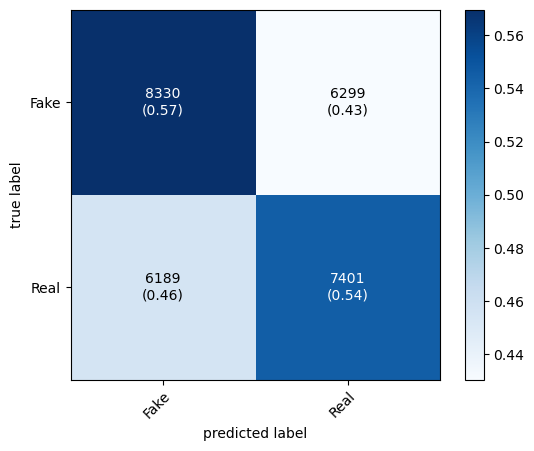

In [12]:
start_time = time.time()
y_pred_test=dt.predict(X_test)
evaluation_time = time.time() - start_time

# Report and confusion matrix
dt_report = classification_report(y_test, y_pred_test, output_dict=True)
accuracy = accuracy_score(y_test, y_pred_test)

results_df.loc[0] = ['Decision Trees',
                     accuracy,
                     dt_report['macro avg']['precision'], 
                     dt_report['macro avg']['recall'], 
                     dt_report['macro avg']['f1-score'], training_time, evaluation_time, max_feat]

print("Decision Trees:")
print(classification_report(y_test, y_pred_test))

print("\n----------------------Confusion Matrix---------------------- \n")
conf_mat = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(conf_mat,
                    show_normed=True, colorbar=True,
                    class_names=['Fake', 'Real'])
plt.show()

Random Forest

In [13]:
start_time = time.time()
clf_rf = RandomForestClassifier()
clf_rf.fit(X_train, y_train)
training_time = time.time() - start_time

Random Forest:
              precision    recall  f1-score   support

           0       0.53      0.54      0.53     14629
           1       0.49      0.48      0.49     13590

    accuracy                           0.51     28219
   macro avg       0.51      0.51      0.51     28219
weighted avg       0.51      0.51      0.51     28219


----------------------Confusion Matrix---------------------- 



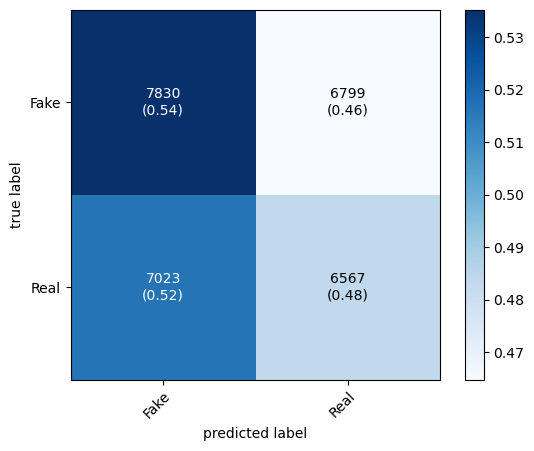

In [14]:
start_time = time.time()
y_pred_test=clf_rf.predict(X_test)
evaluation_time = time.time() - start_time

rf_report = classification_report(y_test, y_pred_test, output_dict=True)
accuracy = accuracy_score(y_test, y_pred_test)

results_df.loc[1] = ['Random Forest',
                     accuracy,
                     rf_report['macro avg']['precision'], 
                     rf_report['macro avg']['recall'], 
                     rf_report['macro avg']['f1-score'], training_time, evaluation_time, max_feat]

print("Random Forest:")
print(classification_report(y_test, y_pred_test))

print("\n----------------------Confusion Matrix---------------------- \n")
conf_mat = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(conf_mat,
                    show_normed=True, colorbar=True,
                    class_names=['Fake', 'Real'])
plt.show()

Extra Trees

In [15]:
start_time = time.time()
clf_et = ExtraTreesClassifier()
clf_et.fit(X_train, y_train)
training_time = time.time() - start_time

Extra Trees:
              precision    recall  f1-score   support

           0       0.42      0.42      0.42     14629
           1       0.37      0.36      0.37     13590

    accuracy                           0.39     28219
   macro avg       0.39      0.39      0.39     28219
weighted avg       0.39      0.39      0.39     28219


----------------------Confusion Matrix---------------------- 



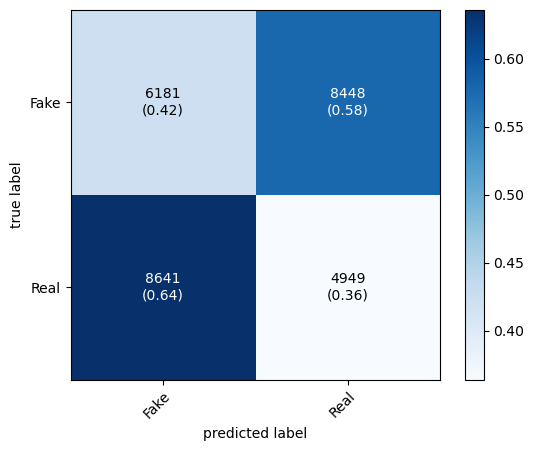

In [16]:
start_time = time.time()
y_pred_test=clf_et.predict(X_test)
evaluation_time = time.time() - start_time

et_report = classification_report(y_test, y_pred_test, output_dict=True)
accuracy = accuracy_score(y_test, y_pred_test)

results_df.loc[2] = ['Extra Trees',
                     accuracy,
                     et_report['macro avg']['precision'], 
                     et_report['macro avg']['recall'], 
                     et_report['macro avg']['f1-score'], training_time, evaluation_time, max_feat]

print("Extra Trees:")
print(classification_report(y_test, y_pred_test))

print("\n----------------------Confusion Matrix---------------------- \n")
conf_mat = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(conf_mat,
                    show_normed=True, colorbar=True,
                    class_names=['Fake', 'Real'])
plt.show()

XGB

In [7]:
start_time = time.time()
clf_xgb = XGBClassifier()
clf_xgb.fit(X_train, y_train)
training_time = time.time() - start_time

XG Boost:
              precision    recall  f1-score   support

           0       0.77      0.75      0.76     14629
           1       0.73      0.76      0.74     13590

    accuracy                           0.75     28219
   macro avg       0.75      0.75      0.75     28219
weighted avg       0.75      0.75      0.75     28219


----------------------Confusion Matrix---------------------- 



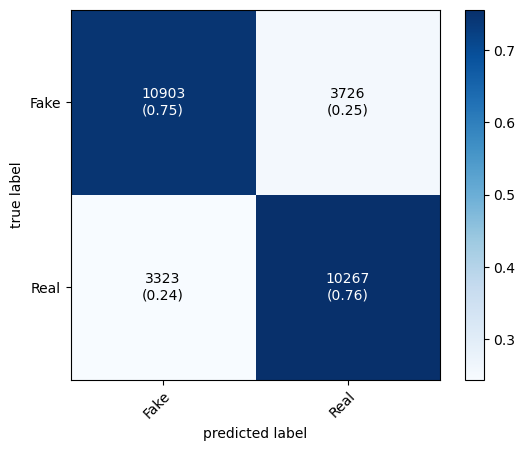

In [8]:
start_time = time.time()
y_pred_test=clf_xgb.predict(X_test)
evaluation_time = time.time() - start_time

xgb_report = classification_report(y_test, y_pred_test, output_dict=True)
accuracy = accuracy_score(y_test, y_pred_test)

results_df.loc[3] = ['XG Boost',
                     accuracy,
                     xgb_report['macro avg']['precision'], 
                     xgb_report['macro avg']['recall'], 
                     xgb_report['macro avg']['f1-score'], training_time, evaluation_time, "No max features"]

print("XG Boost:")
print(classification_report(y_test, y_pred_test))

print("\n----------------------Confusion Matrix---------------------- \n")
conf_mat = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(conf_mat,
                    show_normed=True, colorbar=True,
                    class_names=['Fake', 'Real'])
plt.show()

Adaboost

In [9]:
start_time = time.time()
clf_adab = AdaBoostClassifier()
clf_adab.fit(X_train, y_train)
training_time = time.time() - start_time

Adaboost:
              precision    recall  f1-score   support

           0       0.79      0.61      0.69     14629
           1       0.66      0.83      0.74     13590

    accuracy                           0.72     28219
   macro avg       0.73      0.72      0.71     28219
weighted avg       0.73      0.72      0.71     28219


----------------------Confusion Matrix---------------------- 



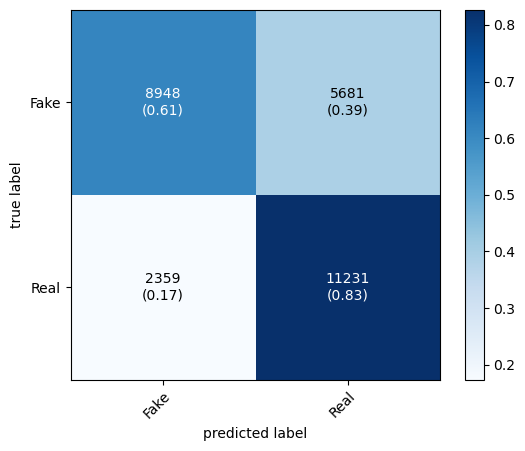

In [10]:
start_time = time.time()
y_pred_test=clf_adab.predict(X_test)
evaluation_time = time.time() - start_time

adab_report = classification_report(y_test, y_pred_test, output_dict=True)
accuracy = accuracy_score(y_test, y_pred_test)

results_df.loc[4] = ['Adaboost',
                     accuracy,
                     adab_report['macro avg']['precision'], 
                     adab_report['macro avg']['recall'], 
                     adab_report['macro avg']['f1-score'], training_time, evaluation_time, max_feat]

print("Adaboost:")
print(classification_report(y_test, y_pred_test))

print("\n----------------------Confusion Matrix---------------------- \n")
conf_mat = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(conf_mat,
                    show_normed=True, colorbar=True,
                    class_names=['Fake', 'Real'])
plt.show()

Gradient Boosting

In [11]:
start_time = time.time()
clf_gb = GradientBoostingClassifier()
clf_gb.fit(X_train, y_train)
training_time = time.time() - start_time

Gradient Boosting:
              precision    recall  f1-score   support

           0       0.79      0.65      0.72     14629
           1       0.69      0.82      0.75     13590

    accuracy                           0.73     28219
   macro avg       0.74      0.73      0.73     28219
weighted avg       0.74      0.73      0.73     28219


----------------------Confusion Matrix---------------------- 



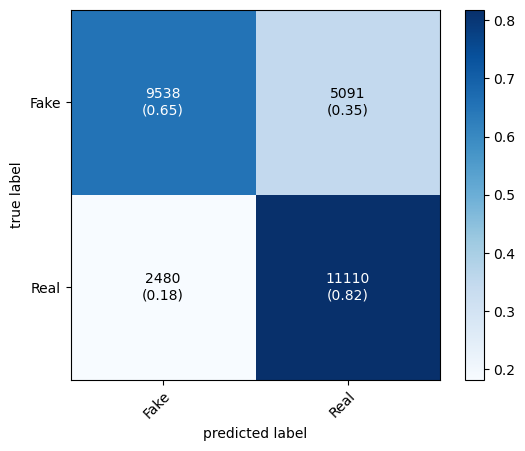

In [12]:
start_time = time.time()
y_pred_test=clf_gb.predict(X_test)
evaluation_time = time.time() - start_time

gb_report = classification_report(y_test, y_pred_test, output_dict=True)
accuracy = accuracy_score(y_test, y_pred_test)

results_df.loc[5] = ['Gradient Boosting',
                     accuracy,
                     gb_report['macro avg']['precision'], 
                     gb_report['macro avg']['recall'], 
                     gb_report['macro avg']['f1-score'], training_time, evaluation_time, max_feat]

print("Gradient Boosting:")
print(classification_report(y_test, y_pred_test))

print("\n----------------------Confusion Matrix---------------------- \n")
conf_mat = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(conf_mat,
                    show_normed=True, colorbar=True,
                    class_names=['Fake', 'Real'])
plt.show()

Bagging

In [23]:
start_time = time.time()
clf_bag = BaggingClassifier()
clf_bag.fit(X_train, y_train)
training_time = time.time() - start_time

Bagging:
              precision    recall  f1-score   support

           0       0.58      0.62      0.60     14629
           1       0.55      0.51      0.53     13590

    accuracy                           0.57     28219
   macro avg       0.57      0.56      0.56     28219
weighted avg       0.57      0.57      0.57     28219


----------------------Confusion Matrix---------------------- 



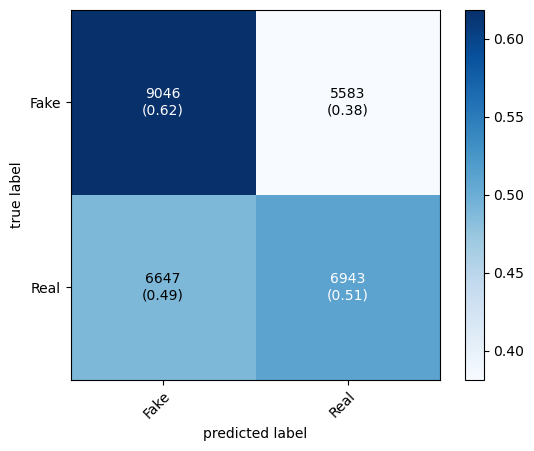

In [24]:
start_time = time.time()
y_pred_test=clf_bag.predict(X_test)
evaluation_time = time.time() - start_time

bag_report = classification_report(y_test, y_pred_test, output_dict=True)
accuracy = accuracy_score(y_test, y_pred_test)

results_df.loc[6] = ['Bagging',
                     accuracy,
                     bag_report['macro avg']['precision'], 
                     bag_report['macro avg']['recall'], 
                     bag_report['macro avg']['f1-score'], training_time, evaluation_time, max_feat]

print("Bagging:")
print(classification_report(y_test, y_pred_test))

print("\n----------------------Confusion Matrix---------------------- \n")
conf_mat = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(conf_mat,
                    show_normed=True, colorbar=True,
                    class_names=['Fake', 'Real'])
plt.show()

Logistic Regression

In [13]:
start_time = time.time()
clf_lr = LogisticRegression(max_iter=500)
clf_lr.fit(X_train, y_train)
training_time = time.time() - start_time

Logistic Regression:
              precision    recall  f1-score   support

           0       0.63      0.63      0.63     14629
           1       0.60      0.61      0.61     13590

    accuracy                           0.62     28219
   macro avg       0.62      0.62      0.62     28219
weighted avg       0.62      0.62      0.62     28219


----------------------Confusion Matrix---------------------- 



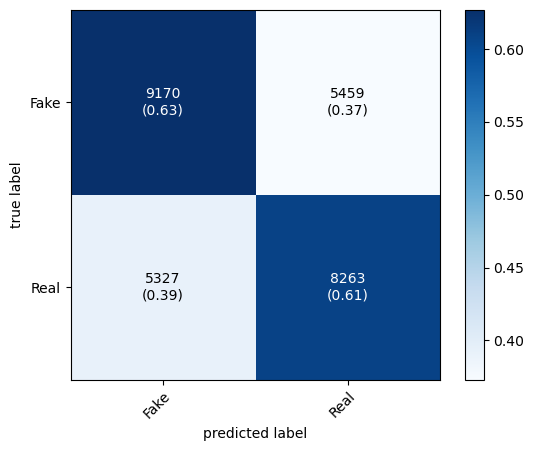

In [14]:
start_time = time.time()
y_pred_test=clf_lr.predict(X_test)
evaluation_time = time.time() - start_time

lr_report = classification_report(y_test, y_pred_test, output_dict=True)
accuracy = accuracy_score(y_test, y_pred_test)

results_df.loc[7] = ['Logistic Regression',
                     accuracy,
                     lr_report['macro avg']['precision'], 
                     lr_report['macro avg']['recall'], 
                     lr_report['macro avg']['f1-score'], training_time, evaluation_time, max_feat]

print("Logistic Regression:")
print(classification_report(y_test, y_pred_test))

print("\n----------------------Confusion Matrix---------------------- \n")
conf_mat = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(conf_mat,
                    show_normed=True, colorbar=True,
                    class_names=['Fake', 'Real'])
plt.show()

SVC

In [27]:
start_time = time.time()
clf_svc = SVC()
clf_svc.fit(X_train, y_train)
training_time = time.time() - start_time

SVC:
              precision    recall  f1-score   support

           0       0.65      0.62      0.64     14629
           1       0.62      0.65      0.63     13590

    accuracy                           0.63     28219
   macro avg       0.63      0.64      0.63     28219
weighted avg       0.64      0.63      0.63     28219


----------------------Confusion Matrix---------------------- 



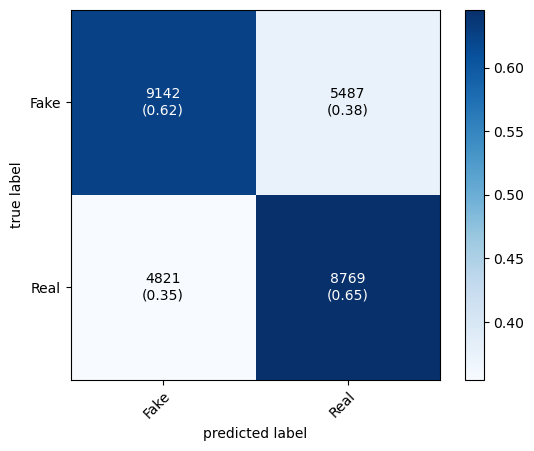

In [28]:
start_time = time.time()
y_pred_test=clf_svc.predict(X_test)
evaluation_time = time.time() - start_time

svc_report = classification_report(y_test, y_pred_test, output_dict=True)
accuracy = accuracy_score(y_test, y_pred_test)

results_df.loc[8] = ['SVC',
                     accuracy,
                     svc_report['macro avg']['precision'], 
                     svc_report['macro avg']['recall'], 
                     svc_report['macro avg']['f1-score'], training_time, evaluation_time, max_feat]

print("SVC:")
print(classification_report(y_test, y_pred_test))

print("\n----------------------Confusion Matrix---------------------- \n")
conf_mat = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(conf_mat,
                    show_normed=True, colorbar=True,
                    class_names=['Fake', 'Real'])
plt.show()

Linear SVC

In [15]:
start_time = time.time()
clf_linsvc = LinearSVC()
clf_linsvc.fit(X_train, y_train)
training_time = time.time() - start_time

Linear SVC:
              precision    recall  f1-score   support

           0       0.59      0.58      0.58     14629
           1       0.56      0.56      0.56     13590

    accuracy                           0.57     28219
   macro avg       0.57      0.57      0.57     28219
weighted avg       0.57      0.57      0.57     28219


----------------------Confusion Matrix---------------------- 



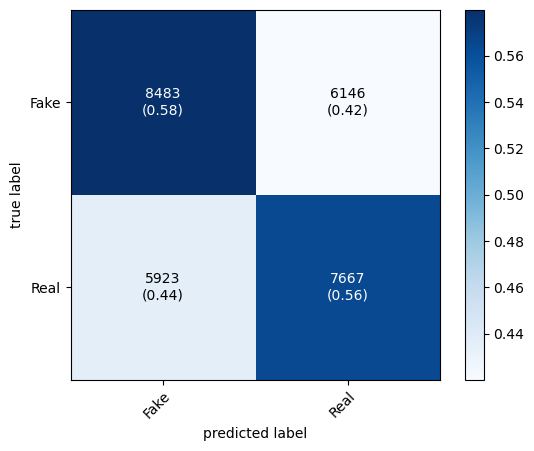

In [16]:
start_time = time.time()
y_pred_test=clf_linsvc.predict(X_test)
evaluation_time = time.time() - start_time

linsvc_report = classification_report(y_test, y_pred_test, output_dict=True)
accuracy = accuracy_score(y_test, y_pred_test)

results_df.loc[9] = ['Linear SVC',
                     accuracy,
                     linsvc_report['macro avg']['precision'], 
                     linsvc_report['macro avg']['recall'], 
                     linsvc_report['macro avg']['f1-score'], training_time, evaluation_time, max_feat]

print("Linear SVC:")
print(classification_report(y_test, y_pred_test))

print("\n----------------------Confusion Matrix---------------------- \n")
conf_mat = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(conf_mat,
                    show_normed=True, colorbar=True,
                    class_names=['Fake', 'Real'])
plt.show()

Multinomial NB

In [17]:
start_time = time.time()
clf_mnb = MultinomialNB()
clf_mnb.fit(X_train, y_train)
training_time = time.time() - start_time

Multinomial NB:
              precision    recall  f1-score   support

           0       0.52      0.58      0.55     14629
           1       0.48      0.43      0.45     13590

    accuracy                           0.50     28219
   macro avg       0.50      0.50      0.50     28219
weighted avg       0.50      0.50      0.50     28219


----------------------Confusion Matrix---------------------- 



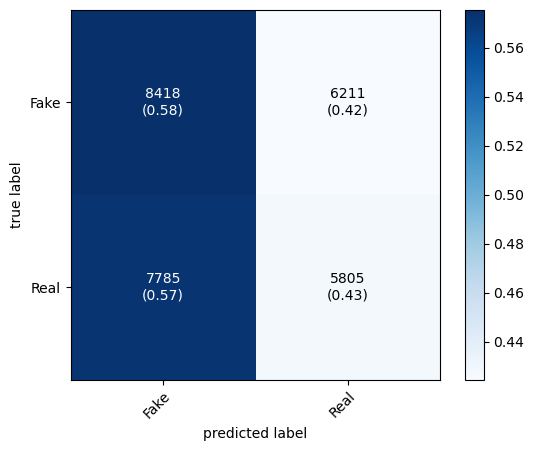

In [18]:
start_time = time.time()
y_pred_test=clf_mnb.predict(X_test)
evaluation_time = time.time() - start_time

mnb_report = classification_report(y_test, y_pred_test, output_dict=True)
accuracy = accuracy_score(y_test, y_pred_test)

results_df.loc[10] = ['Multinomial NB',
                     accuracy,
                     mnb_report['macro avg']['precision'], 
                     mnb_report['macro avg']['recall'], 
                     mnb_report['macro avg']['f1-score'], training_time, evaluation_time, max_feat]

print("Multinomial NB:")
print(classification_report(y_test, y_pred_test))

print("\n----------------------Confusion Matrix---------------------- \n")
conf_mat = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(conf_mat,
                    show_normed=True, colorbar=True,
                    class_names=['Fake', 'Real'])
plt.show()

Bernoulli NB

In [19]:
start_time = time.time()
clf_bnb=BernoulliNB()
clf_bnb.fit(X_train, y_train)
training_time = time.time() - start_time

Bernoulli NB:
              precision    recall  f1-score   support

           0       0.53      0.59      0.56     14629
           1       0.50      0.43      0.46     13590

    accuracy                           0.52     28219
   macro avg       0.51      0.51      0.51     28219
weighted avg       0.52      0.52      0.51     28219


----------------------Confusion Matrix---------------------- 



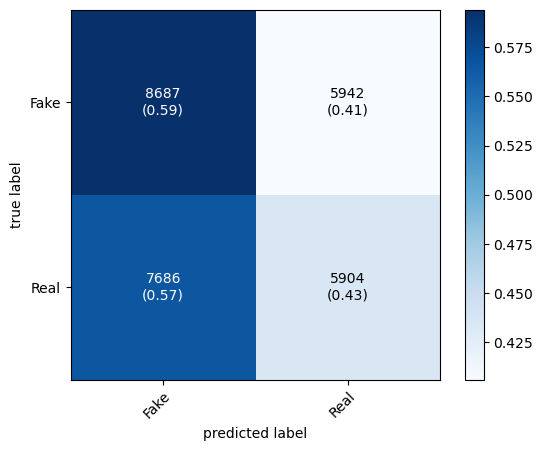

In [20]:
start_time = time.time()
y_pred_test=clf_bnb.predict(X_test)
evaluation_time = time.time() - start_time

bnb_report = classification_report(y_test, y_pred_test, output_dict=True)
accuracy = accuracy_score(y_test, y_pred_test)

results_df.loc[11] = ['Bernoulli NB',
                     accuracy,
                     bnb_report['macro avg']['precision'], 
                     bnb_report['macro avg']['recall'], 
                     bnb_report['macro avg']['f1-score'], training_time, evaluation_time, max_feat]

print("Bernoulli NB:")
print(classification_report(y_test, y_pred_test))

print("\n----------------------Confusion Matrix---------------------- \n")
conf_mat = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(conf_mat,
                    show_normed=True, colorbar=True,
                    class_names=['Fake', 'Real'])
plt.show()

Gaussian NB

In [36]:
try_tfidf = TfidfVectorizer(ngram_range=(1, 3), max_features= 1000)
try_X_tfidf = try_tfidf.fit_transform(df['text']).toarray()

try_X_train, try_X_test, try_y_train, try_y_test = train_test_split(try_X_tfidf, df['label'], test_size=0.2, random_state=42)

start_time = time.time()
clf_gnb=GaussianNB()
clf_gnb.fit(try_X_train, try_y_train)
training_time = time.time() - start_time

Gaussian NB:
              precision    recall  f1-score   support

           0       0.59      0.50      0.54     14629
           1       0.54      0.63      0.58     13590

    accuracy                           0.56     28219
   macro avg       0.56      0.56      0.56     28219
weighted avg       0.56      0.56      0.56     28219


----------------------Confusion Matrix---------------------- 



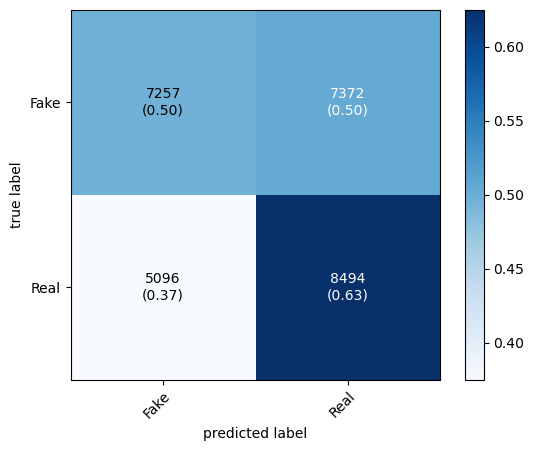

In [37]:
# #changed try vars

start_time = time.time()
try_y_pred_test=clf_gnb.predict(try_X_test)
evaluation_time = time.time() - start_time

gnb_report = classification_report(try_y_test, try_y_pred_test, output_dict=True)
accuracy = accuracy_score(try_y_test, try_y_pred_test)

results_df.loc[12] = ['Gaussian NB',
                     accuracy,
                     gnb_report['macro avg']['precision'], 
                     gnb_report['macro avg']['recall'], 
                     gnb_report['macro avg']['f1-score'], training_time, evaluation_time, 1000]

print("Gaussian NB:")
print(classification_report(try_y_test, try_y_pred_test))

print("\n----------------------Confusion Matrix---------------------- \n")
conf_mat = confusion_matrix(try_y_test, try_y_pred_test)
plot_confusion_matrix(conf_mat,
                    show_normed=True, colorbar=True,
                    class_names=['Fake', 'Real'])
plt.show()

KNN

In [38]:
start_time = time.time()
clf_knn = KNeighborsClassifier(20)
clf_knn.fit(X_train, y_train)
training_time = time.time() - start_time

KNN:
              precision    recall  f1-score   support

           0       0.50      0.77      0.61     14629
           1       0.42      0.18      0.25     13590

    accuracy                           0.48     28219
   macro avg       0.46      0.47      0.43     28219
weighted avg       0.46      0.48      0.44     28219


----------------------Confusion Matrix---------------------- 



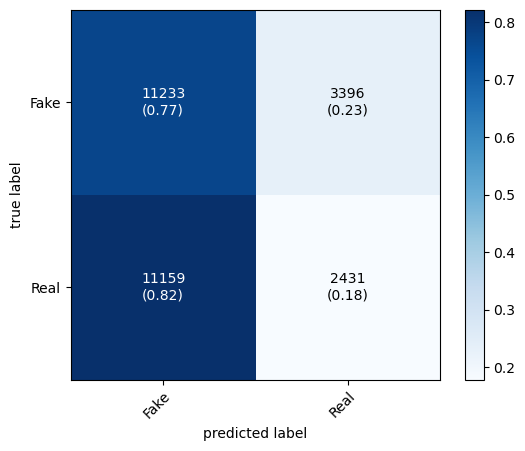

In [39]:
start_time = time.time()
y_pred_test=clf_knn.predict(X_test)
evaluation_time = time.time() - start_time

knn_report = classification_report(y_test, y_pred_test, output_dict=True)
accuracy = accuracy_score(y_test, y_pred_test)

results_df.loc[13] = ['KNN',
                     accuracy,
                     knn_report['macro avg']['precision'], 
                     knn_report['macro avg']['recall'], 
                     knn_report['macro avg']['f1-score'], training_time, evaluation_time, max_feat]

print("KNN:")
print(classification_report(y_test, y_pred_test))

print("\n----------------------Confusion Matrix---------------------- \n")
conf_mat = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(conf_mat,
                    show_normed=True, colorbar=True,
                    class_names=['Fake', 'Real'])
plt.show()